In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, split, substring, when, hour, month, dayofyear
from pyspark.sql.types import DoubleType, TimestampType
from pyspark.sql.functions import radians

# Build the SparkSession
spark = SparkSession.builder \
    .appName("GlobalHourlyWeather") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

print(spark.version)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/10/31 13:31:31 WARN Utils: Your hostname, Neos-MacBook-Pro.local, resolves to a loopback address: 127.0.0.1; using 172.31.115.162 instead (on interface en0)
25/10/31 13:31:31 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/31 13:31:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


4.0.1


In [2]:
# Update this path to where your unzipped '2024' folder is
data_path = "2024.tar.gz"

# Load all CSVs, using the first file's header
df = spark.read.csv(data_path, header=True, inferSchema=True)

# Let's see what we've got!
df.printSchema()
df.show(5, truncate=False)

root
 |-- 01001099999.csv                                                                                     0100644 0000000 0000000 00010620251 14760163177 011523  0                                                                                                    ustar 00                                                                0000000 0000000                                                                                                                                                                        "STATION": string (nullable = true)
 |-- DATE: string (nullable = true)
 |-- SOURCE: string (nullable = true)
 |-- LATITUDE: string (nullable = true)
 |-- LONGITUDE: string (nullable = true)
 |-- ELEVATION: string (nullable = true)
 |-- NAME: string (nullable = true)
 |-- REPORT_TYPE: string (nullable = true)
 |-- CALL_SIGN: string (nullable = true)
 |-- QUALITY_CONTROL: string (nullable = true)
 |-- WND: string (nullable = true)
 |-- CIG: string (nullable = true)
 |-- VIS:

25/10/31 13:34:01 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


## Parse and clean the target variable

In [3]:
# ----- THIS IS THE FIX -----
# First, filter out any rows where TMP doesn't have a comma (or is null)
df_with_comma = df.where(col("TMP").contains(","))
# ---------------------------

# 1. Split TMP into its value and quality flag
# Now, we use df_with_comma, not df
df_parsed = df_with_comma.withColumn("tmp_parts", split(col("TMP"), ","))

# 2. Separate the value and flag into their own columns
# This is now safe because we know a comma exists
df_parsed = df_parsed.withColumn("tmp_value", col("tmp_parts")[0]) \
                     .withColumn("tmp_flag", col("tmp_parts")[1])

# 3. Filter out bad data *before* scaling
df_cleaned = df_parsed.where(
    (col("tmp_value") != "+9999") &
    (col("tmp_flag").isin(['1', '5']))
)

# 4. Cast to a number and apply the scaling factor (divide by 10)
df_with_temp = df_cleaned.withColumn(
    "temperature",
    col("tmp_value").cast(DoubleType()) / 10.0
)

# Let's check our work!
print("Original vs. Cleaned Temperature:")
df_with_temp.select("TMP", "temperature").show(10)

# See how many rows we kept
print(f"Total records after cleaning TMP: {df_with_temp.count()}")

Original vs. Cleaned Temperature:
+-------+-----------+
|    TMP|temperature|
+-------+-----------+
|-0070,1|       -7.0|
|-0065,1|       -6.5|
|-0065,1|       -6.5|
|-0064,1|       -6.4|
|-0070,1|       -7.0|
|-0057,1|       -5.7|
|-0052,1|       -5.2|
|-0057,1|       -5.7|
|-0047,1|       -4.7|
|-0042,1|       -4.2|
+-------+-----------+
only showing top 10 rows


Total records after cleaning TMP: 122341374


## Feature engineering

Based on that doc, your main goal is to parse DEW, SLP, and WND in the same way you parsed TMP. These columns are strong predictors of temperature.

Why These Features?

    DEW (Dew Point): This is the single most important predictor after time and location. The dew point is the temperature at which air becomes saturated. The difference between temperature and dew_point (called the "spread") directly relates to relative humidity, which is a massive factor in how much the temperature can change.

    SLP (Sea Level Pressure): High pressure and low pressure systems are what cause large-scale weather and temperature changes. This is a very strong feature.

    WND (Wind Observation): This column contains both wind direction and speed. Wind speed, in particular, has a strong effect on temperature (e.g., wind chill, mixing of air).

### Define the cleaning function

In [4]:
from pyspark.sql.functions import col, split
from pyspark.sql.types import DoubleType

def clean_weather_column(input_df, col_name, missing_code, quality_flags, scale_factor):
    """
    Cleans a NOAA weather column that has a 'value,flag' format.
    
    :param input_df: The DataFrame to transform
    :param col_name: The name of the raw column to clean (e.g., "DEW", "SLP")
    :param missing_code: The string code for missing values (e.g., "+9999", "99999")
    :param quality_flags: A list of good-quality flags to keep (e.g., ['1', '5'])
    :param scale_factor: The number to divide the value by (e.g., 10.0)
    :return: A new DataFrame with a clean column named '<col_name>_clean'
    """
    print(f"Cleaning column: {col_name}...")
    
    # 1. Filter out rows without a comma (like we did for TMP)
    df_with_comma = input_df.where(col(col_name).contains(","))

    # 2. Split into value and flag
    df_parsed = df_with_comma.withColumn(f"{col_name}_parts", split(col(col_name), ","))
    
    df_parsed = df_parsed.withColumn(f"{col_name}_value", col(f"{col_name}_parts")[0]) \
                         .withColumn(f"{col_name}_flag", col(f"{col_name}_parts")[1])

    # 3. Filter out bad data
    df_cleaned = df_parsed.where(
        (col(f"{col_name}_value") != missing_code) &
        (col(f"{col_name}_flag").isin(quality_flags))
    )
    
    # 4. Create the final scaled, numeric column
    clean_col_name = col_name.lower() + "_clean" # e.g., 'dew_clean'
    
    df_final = df_cleaned.withColumn(
        clean_col_name,
        col(f"{col_name}_value").cast(DoubleType()) / scale_factor
    )
    
    # 5. Drop the intermediate columns
    df_final = df_final.drop(col_name, f"{col_name}_parts", f"{col_name}_value", f"{col_name}_flag")
    
    return df_final

### Firstly, parse the date and cast the geographic column

In [5]:
# Remove the month for feature engineering
# Make sure these imports are at the top
from pyspark.sql.functions import sin, cos, pi, hour, month, dayofyear, col
from pyspark.sql.types import DoubleType, TimestampType

# 1. Parse the DATE column
df_featured = df_with_temp.withColumn("timestamp", col("DATE").cast(TimestampType()))

# 2. Extract base time features
# (NOTICE 'month' IS NO LONGER EXTRACTED)
df_with_time = df_featured.withColumn("hour", hour(col("timestamp"))) \
                            .withColumn("day_of_year", dayofyear(col("timestamp")))

# 3. Create cyclical features
df_cyclical = df_with_time.withColumn("hour_sin", sin(2 * pi() * col("hour") / 24)) \
                           .withColumn("hour_cos", cos(2 * pi() * col("hour") / 24)) \
                           .withColumn("day_sin", sin(2 * pi() * col("day_of_year") / 366)) \
                           .withColumn("day_cos", cos(2 * pi() * col("day_of_year") / 366))

# 4. Geographic features - Cast Elevation & Create Spherical Embedding for Lat/Lon
df_geo = df_cyclical.withColumn("latitude_num", col("LATITUDE").cast(DoubleType())) \
                    .withColumn("longitude_num", col("LONGITUDE").cast(DoubleType())) \
                    .withColumn("elevation", col("ELEVATION").cast(DoubleType())) # Keep elevation as is

# Convert degrees to radians
df_geo = df_geo.withColumn("lat_rad", radians(col("latitude_num")))
df_geo = df_geo.withColumn("lon_rad", radians(col("longitude_num")))

# Convert to cartesian coordinates (x, y, z)
df_geo = df_geo.withColumn("geo_x", cos(col("lat_rad")) * cos(col("lon_rad")))
df_geo = df_geo.withColumn("geo_y", cos(col("lat_rad")) * sin(col("lon_rad")))
df_geo = df_geo.withColumn("geo_z", sin(col("lat_rad")))

# Drop intermediate and original lat/lon columns
df_featured = df_geo.drop("latitude_num", "longitude_num", "lat_rad", "lon_rad")

# df_featured now has geo_x, geo_y, geo_z instead of latitude, longitude

# # 5. Run your custom 'clean_weather_column' functions
# # (e.g., for DEW and SLP)
# df_featured = clean_weather_column(
#     input_df=df_featured,
#     col_name="DEW",
#     missing_code="+9999",
#     quality_flags=['1', '5'],
#     scale_factor=10.0
# )

# df_featured = clean_weather_column(
#     input_df=df_featured,
#     col_name="SLP",
#     missing_code="99999",
#     quality_flags=['1', '5'],
#     scale_factor=10.0
# )

# 6. Check our new features
print("Schema after feature engineering (no 'month' cyclical features):")
df_featured.printSchema()

Schema after feature engineering (no 'month' cyclical features):
root
 |-- 01001099999.csv                                                                                     0100644 0000000 0000000 00010620251 14760163177 011523  0                                                                                                    ustar 00                                                                0000000 0000000                                                                                                                                                                        "STATION": string (nullable = true)
 |-- DATE: string (nullable = true)
 |-- SOURCE: string (nullable = true)
 |-- LATITUDE: string (nullable = true)
 |-- LONGITUDE: string (nullable = true)
 |-- elevation: double (nullable = true)
 |-- NAME: string (nullable = true)
 |-- REPORT_TYPE: string (nullable = true)
 |-- CALL_SIGN: string (nullable = true)
 |-- QUALITY_CONTROL: string (nullable = true)
 |-- WND: stri

In [6]:
# # 1. Parse the DATE column
# df_featured = df_with_temp.withColumn("timestamp", col("DATE").cast(TimestampType()))

# # 2. Extract time-based features
# df_featured = df_featured.withColumn("hour", hour(col("timestamp"))) \
#                          .withColumn("month", month(col("timestamp"))) \
#                          .withColumn("day_of_year", dayofyear(col("timestamp")))

# # 3. Cast geographic features to numeric
# df_featured = df_featured.withColumn("latitude", col("LATITUDE").cast(DoubleType())) \
#                          .withColumn("longitude", col("LONGITUDE").cast(DoubleType())) \
#                          .withColumn("elevation", col("ELEVATION").cast(DoubleType()))

# # 4. (Recommended) Parse other weather features
# # You must repeat the "Parse and Clean" logic for any other
# # weather columns you want to use, like 'DEW' (Dew Point) or 'WND' (Wind).
# # Check the dataset documentation for their specific flags and scaling factors.

# # Let's check our new features
# print("Schema after feature engineering:")
# df_featured.printSchema()

# print("\nSample of new features:")
# df_featured.select("timestamp", "hour", "month", "latitude", "elevation").show(10)

### Clean the feature DEW (Dew Point) and SLP (Sea Level Pressure)

In [7]:
# We start with df_featured from the previous step
df_final_features = df_featured

# Clean the DEW column
# Missing code: +9999, Quality flags: '1', '5', Scale: 10.0
df_final_features = clean_weather_column(
    input_df=df_final_features,
    col_name="DEW",
    missing_code="+9999",
    quality_flags=['1', '5'],
    scale_factor=10.0
)

# Clean the SLP column
# Missing code: 99999, Quality flags: '1', '5', Scale: 10.0
df_final_features = clean_weather_column(
    input_df=df_final_features,
    col_name="SLP",
    missing_code="99999",
    quality_flags=['1', '5'],
    scale_factor=10.0
)

# Check our new clean columns
df_final_features.select("temperature", "dew_clean", "slp_clean").show(10)

Cleaning column: DEW...
Cleaning column: SLP...
+-----------+---------+---------+
|temperature|dew_clean|slp_clean|
+-----------+---------+---------+
|       -7.0|    -13.0|   1020.8|
|       -6.5|    -12.4|   1020.4|
|       -6.5|    -11.3|   1020.5|
|       -6.4|    -10.5|   1020.2|
|       -7.0|    -10.6|   1020.0|
|       -5.7|     -9.9|   1019.6|
|       -5.2|     -9.5|   1019.6|
|       -5.7|     -9.9|   1019.5|
|       -4.7|     -8.6|   1019.2|
|       -4.2|     -7.7|   1018.7|
+-----------+---------+---------+
only showing top 10 rows


### Now for the WND column

The WND (Wind) column is more complex. It's not just one value and a flag. It's typically: Direction, DirectionQuality, Type, Speed, SpeedQuality
You'll need a separate, custom-parsing logic for this

In [8]:
# 1. Split WND into its 5 parts
wnd_parts = split(col("WND"), ",")

# 2. Get the Speed (index 3) and SpeedQuality (index 4)
df_wind = df_final_features.withColumn("wind_speed_raw", wnd_parts[3])
df_wind = df_wind.withColumn("wind_speed_flag", wnd_parts[4])

# 3. Clean and scale it
df_wind_cleaned = df_wind.where(
    (col("wind_speed_raw") != "9999") &
    (col("wind_speed_flag").isin(['1', '5']))
)

df_wind_final = df_wind_cleaned.withColumn(
    "wind_speed_clean",
    col("wind_speed_raw").cast(DoubleType()) / 10.0  # Assuming 10.0 scale, check docs!
)

# See the result
df_wind_final.select("WND", "wind_speed_clean").show(10)

+--------------+----------------+
|           WND|wind_speed_clean|
+--------------+----------------+
|318,1,N,0061,1|             6.1|
|330,1,N,0051,1|             5.1|
|348,1,N,0035,1|             3.5|
|357,1,N,0019,1|             1.9|
|241,1,N,0008,1|             0.8|
|076,1,N,0048,1|             4.8|
|084,1,N,0054,1|             5.4|
|040,1,N,0023,1|             2.3|
|098,1,N,0057,1|             5.7|
|086,1,N,0063,1|             6.3|
+--------------+----------------+
only showing top 10 rows


### CIG and VIS

In [9]:
from pyspark.sql.functions import col, split
from pyspark.sql.types import DoubleType

# Make sure the input DataFrame name matches the output of the WND cell
df_feat = df_wind_final 

print("Parsing CIG and VIS...")

# --- Parse CIG (cloud ceiling height) - 1st value ---
# Filter, split, extract height (index 0) & flag (index 1)
df_cig = df_feat.where(col("CIG").isNotNull() & col("CIG").contains(","))
df_cig = (
    df_cig.withColumn("cig_parts", split(col("CIG"), ","))
    .withColumn("cig_value", col("cig_parts").getItem(0)) # Use getItem for safety
    .withColumn("cig_flag", col("cig_parts").getItem(1)) # Use getItem for safety
)
# Filter missing ("99999") and bad quality flags (assuming '1', '5')
df_cig = df_cig.where(
    (col("cig_value") != "99999") & (col("cig_flag").isin(["1", "5"])) # Verify flags
)
# Cast height (assuming no scaling needed)
df_feat = df_cig.withColumn("ceiling_height_clean", col("cig_value").cast(DoubleType()))
df_feat = df_feat.drop("cig_parts", "cig_value", "cig_flag", "CIG")


# --- Parse VIS (horizontal visibility) - 1st value ---
# Filter, split, extract distance (index 0) & flag (index 1)
df_vis = df_feat.where(col("VIS").isNotNull() & col("VIS").contains(","))
df_vis = (
    df_vis.withColumn("vis_parts", split(col("VIS"), ","))
    .withColumn("vis_value", col("vis_parts").getItem(0)) # Use getItem
    .withColumn("vis_flag", col("vis_parts").getItem(1)) # Use getItem
)
# Filter missing ("999999") and bad quality flags (assuming '1', '5')
df_vis = df_vis.where(
    (col("vis_value") != "999999") & (col("vis_flag").isin(["1", "5"])) # Verify flags
)
# Cast distance (assuming no scaling needed)
df_feat = df_vis.withColumn("visibility_dist_clean", col("vis_value").cast(DoubleType()))
df_feat = df_feat.drop("vis_parts", "vis_value", "vis_flag", "VIS")

# Rename the final DataFrame to match what subsequent cells expect
df_final_features = df_feat 

print("Finished parsing CIG, VIS.")
df_final_features.select("wind_speed_clean", "ceiling_height_clean", "visibility_dist_clean").show(5)

Parsing CIG and VIS...
Finished parsing CIG, VIS.
+----------------+--------------------+---------------------+
|wind_speed_clean|ceiling_height_clean|visibility_dist_clean|
+----------------+--------------------+---------------------+
|             6.8|               600.0|              25000.0|
|             8.0|               600.0|              25000.0|
|             5.9|               300.0|              10000.0|
|             4.4|               300.0|              10000.0|
|             3.2|               300.0|              10000.0|
+----------------+--------------------+---------------------+
only showing top 5 rows


## Checking after cleaning and engineering

In [10]:
# Run this in a new cell
df_final_features.printSchema()

root
 |-- 01001099999.csv                                                                                     0100644 0000000 0000000 00010620251 14760163177 011523  0                                                                                                    ustar 00                                                                0000000 0000000                                                                                                                                                                        "STATION": string (nullable = true)
 |-- DATE: string (nullable = true)
 |-- SOURCE: string (nullable = true)
 |-- LATITUDE: string (nullable = true)
 |-- LONGITUDE: string (nullable = true)
 |-- elevation: double (nullable = true)
 |-- NAME: string (nullable = true)
 |-- REPORT_TYPE: string (nullable = true)
 |-- CALL_SIGN: string (nullable = true)
 |-- QUALITY_CONTROL: string (nullable = true)
 |-- WND: string (nullable = true)
 |-- TMP: string (nullable = true)
 |-- AA1:

In [11]:
# 1. Define the list of all our final numeric features
# (We check the sin/cos features, not the originals)
numeric_cols = [
    # Target Variable
    "temperature", 
    # Geographic Features (New)
    "elevation", 
    "geo_x", "geo_y", "geo_z", 
    # Weather Features (Original + New)
    "dew_clean", 
    "slp_clean", 
    "wind_speed_clean",
    "ceiling_height_clean",
    "visibility_dist_clean",
    # Time Features (Cyclical)
    "hour_sin", "hour_cos",
    "day_sin", "day_cos"
]

# 2. Get the statistics for just those columns
print("Checking statistics for new features:")
df_final_features.select(numeric_cols).describe().show()

Checking statistics for new features:


+-------+------------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+------------------+--------------------+---------------------+--------------------+--------------------+--------------------+--------------------+
|summary|       temperature|         elevation|              geo_x|              geo_y|              geo_z|         dew_clean|         slp_clean|  wind_speed_clean|ceiling_height_clean|visibility_dist_clean|            hour_sin|            hour_cos|             day_sin|             day_cos|
+-------+------------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+------------------+--------------------+---------------------+--------------------+--------------------+--------------------+--------------------+
|  count|          21538227|          21538227|           21538227|           21538227|           21538227|          2153822

### Checking for both `NULL` and `NaN` value

In [12]:
# Checking for Null or Nan Value
from pyspark.sql.functions import count, when, isnan

# We'll use the same list of columns from before
cols_to_check = numeric_cols 

# This command counts nulls AND NaNs for each column
df_final_features.select([
    count(when(col(c).isNull() | isnan(c), c)).alias(c) 
    for c in cols_to_check
]).show()

+-----------+---------+-----+-----+-----+---------+---------+----------------+--------------------+---------------------+--------+--------+-------+-------+
|temperature|elevation|geo_x|geo_y|geo_z|dew_clean|slp_clean|wind_speed_clean|ceiling_height_clean|visibility_dist_clean|hour_sin|hour_cos|day_sin|day_cos|
+-----------+---------+-----+-----+-----+---------+---------+----------------+--------------------+---------------------+--------+--------+-------+-------+
|          0|        0|    0|    0|    0|        0|        0|               0|                   0|                    0|       0|       0|      0|      0|
+-----------+---------+-----+-----+-----+---------+---------+----------------+--------------------+---------------------+--------+--------+-------+-------+



In [13]:
# Spot-check the final data
df_final_features.select(numeric_cols).show(20)

+-----------+---------+------------------+--------------------+-----------------+---------+---------+----------------+--------------------+---------------------+--------------------+--------------------+--------------------+------------------+
|temperature|elevation|             geo_x|               geo_y|            geo_z|dew_clean|slp_clean|wind_speed_clean|ceiling_height_clean|visibility_dist_clean|            hour_sin|            hour_cos|             day_sin|           day_cos|
+-----------+---------+------------------+--------------------+-----------------+---------+---------+----------------+--------------------+---------------------+--------------------+--------------------+--------------------+------------------+
|       -2.0|      9.0|0.3229381072207145|-0.04922421478100504|0.945139119698204|     -5.2|   1017.2|             6.8|               600.0|              25000.0|1.224646799147353...|                -1.0| 0.01716632975470737|0.9998526477050269|
|       -0.7|      9.0|0

## Exploratory data analysis (EDA) 

Using a heatmap for understanding of the relationships between features

Sampling data for heatmap...
Converting sample to Pandas...


Sample size for heatmap: 21352 rows
Calculating correlation matrix...
Plotting Correlation Heatmap:


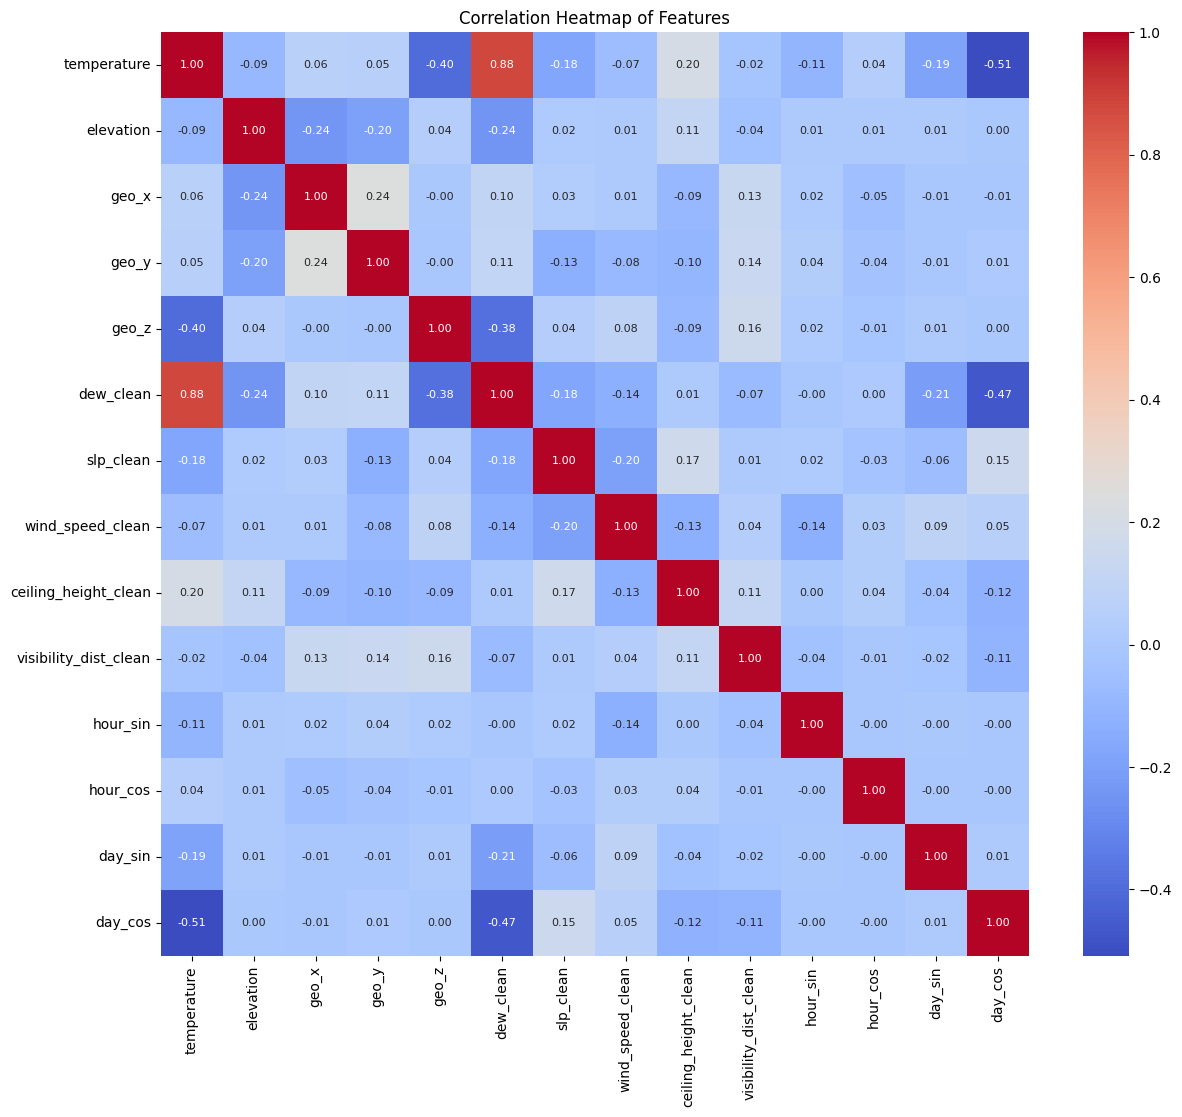

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Ensure pandas is imported

# 1. Define the final list of columns for correlation 
#    (including target and ALL final features)
numeric_cols = [
    # Target Variable
    "temperature", 
    # Geographic Features (New)
    "elevation", 
    "geo_x", "geo_y", "geo_z", 
    # Weather Features (Original + New)
    "dew_clean", 
    "slp_clean", 
    "wind_speed_clean", 
    "ceiling_height_clean", 
    "visibility_dist_clean", 
    # Time Features (Cyclical)
    "hour_sin", "hour_cos",
    "day_sin", "day_cos"
]

# 2. Select ONLY these columns and filter bad elevation data
#    Make sure df_final_features is the correct DataFrame name after parsing WND/CIG/VIS
df_for_corr = df_final_features.where(col("elevation") != -999.9) \
                               .select(numeric_cols)

# 3. Take a small, random sample (e.g., 0.1% = 0.001)
print("Sampling data for heatmap...")
sample_df = df_for_corr.sample(withReplacement=False, fraction=0.001, seed=42)

# 4. Convert the sample to Pandas
print("Converting sample to Pandas...")
pandas_df = sample_df.toPandas()
print(f"Sample size for heatmap: {len(pandas_df)} rows")

# 5. Calculate the Pearson correlation matrix
print("Calculating correlation matrix...")
corr_matrix = pandas_df.corr()

# 6. Plot the heatmap (ONLY ONCE)
print("Plotting Correlation Heatmap:")
plt.figure(figsize=(14, 12)) # Slightly larger figure for more features
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", annot_kws={"size": 8}) # Adjust font size if needed
plt.title("Correlation Heatmap of Features") # Add a title
plt.show() # Display the plot

Correlation Heatmap Analysis

Here's a breakdown of the key insights from the heatmap:

1. Strongest Predictors (Temperature Row)

    dew_clean (0.88): A very strong positive correlation (bright red). This is the most powerful single predictor of temperature, which makes physical sense.

    day_cos (-0.44): The strongest seasonal feature. The negative correlation is correct—it means that as day_cos moves from +1 (winter) to -1 (summer), the temperature increases.

    latitude (-0.40): A moderate negative correlation. As latitude increases (moving north), the temperature tends to drop.

2. No Multicollinearity

    There are no bright red (> 0.9) or dark blue (< -0.9) squares between any two predictor features.

    Conclusion: This is great news. It means all your features are providing unique information without being redundant.

3. Cyclical Encoding is Correct

    The correlation between hour_sin and hour_cos is 0.00.

    The correlation between day_sin and day_cos is 0.00.

    Conclusion: This is the mathematical proof that the sine/cosine encoding was done correctly.

### Final filter and pipeline prep

Look at the describe() output for elevation:

    min: -999.9

This -999.9 is a sentinel value, which is just another code for "missing data" that the documentation didn't explicitly state (it's a common one for this dataset). A real elevation of -999.9 meters is not physically possible (the lowest point on Earth is around -430m).

If we leave this in, it will completely break the StandardScaler and ruin our model.

Here's the code for the next cell. This cell will:

    Create our final, model-ready DataFrame (model_ready_df).

    Define the Spark Pipeline for VectorAssembler and StandardScaler.

    Split the data into training and test sets.

In [15]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

# 1. Define our final feature and label columns
feature_cols = [
    # Geographic features (New Embedding + Elevation)
    "elevation", 
    "geo_x", "geo_y", "geo_z", 
    # Weather features (Original + New Parsed)
    "dew_clean", 
    "slp_clean", 
    "wind_speed_clean",
    "ceiling_height_clean",
    "visibility_dist_clean",
    # Time features (Cyclical)
    "hour_sin", "hour_cos",
    "day_sin", "day_cos"
]

label_col = "temperature"

# 2. Select only these columns AND filter out the bad elevation data
model_df = df_final_features \
    .select(*feature_cols, label_col) \
    .where(col("elevation") != -999.9)

print(f"Original count: {df_final_features.count()}")
print(f"Count after elevation filter: {model_df.count()}")

# 3. Create the VectorAssembler
# This combines all feature columns into one vector
assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)

# 4. Create the StandardScaler
# This scales the "features" vector
scaler = StandardScaler(
    inputCol="features",
    outputCol="scaledFeatures",
    withStd=True,
    withMean=True
)

# 5. Define the preprocessing pipeline
preprocessing_pipeline = Pipeline(stages=[assembler, scaler])

# 6. "Fit" the pipeline to the data
# This learns the mean and stddev for the scaler
preprocessing_model = preprocessing_pipeline.fit(model_df)

# 7. "Transform" the data
# This applies the assembly and scaling
processed_df = preprocessing_model.transform(model_df)

# 8. Select the final columns for modeling and rename label
# We only need the scaled features and the label
final_data = processed_df.select(
    col("scaledFeatures").alias("features"),
    col(label_col).alias("label")
)

# 9. Split the dataset (70% train, 30% test)
(train_data, test_data) = final_data.randomSplit([0.7, 0.3], seed=42)

# 10. Cache the data (important for speed!)
train_data.cache()
test_data.cache()

print("\n--- Preprocessing Complete ---")
print(f"Training set count: {train_data.count()}")
print(f"Test set count: {test_data.count()}")
print("\nReady for modeling:")
train_data.show(5, truncate=False)

Original count: 21538227


Count after elevation filter: 21532405



--- Preprocessing Complete ---


25/10/31 14:03:04 WARN MemoryStore: Not enough space to cache rdd_88_0 in memory! (computed 185.4 MiB so far)
25/10/31 14:03:04 WARN BlockManager: Persisting block rdd_88_0 to disk instead.
25/10/31 14:03:10 WARN MemoryStore: Not enough space to cache rdd_88_0 in memory! (computed 1560.1 MiB so far)
25/10/31 14:03:11 WARN MemoryStore: Not enough space to cache rdd_88_0 in memory! (computed 1560.1 MiB so far)


Training set count: 15077489


25/10/31 14:07:28 WARN MemoryStore: Not enough space to cache rdd_101_0 in memory! (computed 185.4 MiB so far)
25/10/31 14:07:28 WARN BlockManager: Persisting block rdd_101_0 to disk instead.


Test set count: 6454916

Ready for modeling:
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|features                                                                                                                                                                                                                                                      |label|
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|[-1.4972657805452423,1.631035074845793,1.6749103499281888,-0.3131222314888888,-0.575450685557215,0.9457301502146755,-0.50008611335208,0.9799218414807638,-0.725008072

25/10/31 14:07:32 WARN MemoryStore: Not enough space to cache rdd_88_0 in memory! (computed 1560.1 MiB so far)


### Baseline Model: Linear Regression

In [16]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# 1. Define the model
lr = LinearRegression(featuresCol="features", labelCol="label")

# 2. Train the model
print("Training Linear Regression model...")
lr_model = lr.fit(train_data)

# 3. Make predictions on the test data
print("Evaluating model on test data...")
lr_predictions = lr_model.transform(test_data)

# 4. Evaluate the model
# We'll use RMSE (Root Mean Squared Error)
evaluator = RegressionEvaluator(
    labelCol="label", 
    predictionCol="prediction", 
    metricName="rmse"
)

rmse = evaluator.evaluate(lr_predictions)
print(f"\n--- Linear Regression Results ---")
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

# We can also check R-squared (R2)
r2_evaluator = RegressionEvaluator(
    labelCol="label", 
    predictionCol="prediction", 
    metricName="r2"
)
r2 = r2_evaluator.evaluate(lr_predictions)
print(f"R-squared (R2) on test data = {r2}")

# Look at some predictions
print("\nSample predictions:")
lr_predictions.select("label", "prediction").show(10)

25/10/31 14:07:32 WARN Instrumentation: [2e0e8c02] regParam is zero, which might cause numerical instability and overfitting.


Training Linear Regression model...


25/10/31 14:07:33 WARN MemoryStore: Not enough space to cache rdd_88_0 in memory! (computed 1560.1 MiB so far)
25/10/31 14:07:33 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/10/31 14:07:39 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
25/10/31 14:07:40 WARN MemoryStore: Not enough space to cache rdd_88_0 in memory! (computed 1560.1 MiB so far)


Evaluating model on test data...



--- Linear Regression Results ---
Root Mean Squared Error (RMSE) on test data = 5.037770531212898


R-squared (R2) on test data = 0.8390510789333632

Sample predictions:
+-----+------------------+
|label|        prediction|
+-----+------------------+
| 16.0|1.6553427500989315|
| 24.0|10.954350390882297|
| 24.6|11.712100273924944|
| 14.0|10.912847777325894|
| 21.4|  11.1167697235563|
| 22.6|11.417486029895562|
| 23.8|12.847282037416234|
| 19.8| 8.040327182680802|
| 22.4|12.832230407539946|
| 18.2| 9.017316950496369|
+-----+------------------+
only showing top 10 rows


In [19]:
# Calculate MAE using the existing predictions
mae = evaluator.evaluate(lr_predictions, {evaluator.metricName: "mae"})

print(f"Mean Absolute Error (MAE) for Linear Regression = {mae}")

Mean Absolute Error (MAE) for Linear Regression = 3.6152530887644323


### Second baseline model: Gradient-Boosted Tree (GBT) Regressor

In [17]:
from pyspark.ml.regression import GBTRegressor

# 1. Define the model
gbt = GBTRegressor(featuresCol="features", labelCol="label")

# 2. Train the model
print("Training Gradient-Boosted Tree (GBT) model...")
gbt_model = gbt.fit(train_data)

# 3. Make predictions on the test data
print("Evaluating model on test data...")
gbt_predictions = gbt_model.transform(test_data)

# 4. Evaluate the model (using the same 'rmse' evaluator from before)
print("\n--- GBT Regressor Results ---")
rmse = evaluator.evaluate(gbt_predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

# We can also check R-squared
r2 = evaluator.evaluate(gbt_predictions, {evaluator.metricName: "r2"})
print(f"R-squared (R2) on test data = {r2}")

# Look at some predictions
print("\nSample predictions:")
gbt_predictions.select("label", "prediction").show(10)

Training Gradient-Boosted Tree (GBT) model...


25/10/31 14:07:46 WARN MemoryStore: Not enough space to cache rdd_88_0 in memory! (computed 1560.1 MiB so far)
25/10/31 14:07:47 WARN MemoryStore: Not enough space to cache rdd_88_0 in memory! (computed 1560.1 MiB so far)
25/10/31 14:07:53 WARN MemoryStore: Not enough space to cache rdd_88_0 in memory! (computed 1560.1 MiB so far)
25/10/31 14:07:59 WARN MemoryStore: Not enough space to cache rdd_88_0 in memory! (computed 1560.1 MiB so far)
25/10/31 14:08:02 WARN MemoryStore: Not enough space to cache rdd_185_0 in memory! (computed 564.5 MiB so far)
25/10/31 14:08:02 WARN BlockManager: Persisting block rdd_185_0 to disk instead.
25/10/31 14:08:20 WARN MemoryStore: Not enough space to cache rdd_205_0 in memory! (computed 624.0 MiB so far)
25/10/31 14:08:20 WARN BlockManager: Persisting block rdd_205_0 to disk instead.
25/10/31 14:08:24 WARN MemoryStore: Not enough space to cache rdd_205_0 in memory! (computed 624.0 MiB so far)
25/10/31 14:08:25 WARN MemoryStore: Not enough space to cache

Evaluating model on test data...

--- GBT Regressor Results ---


Root Mean Squared Error (RMSE) on test data = 3.9701468978091836


R-squared (R2) on test data = 0.9000404116751486

Sample predictions:
+-----+------------------+
|label|        prediction|
+-----+------------------+
| 16.0| 8.957869265136855|
| 24.0|  16.1846702747226|
| 24.6|14.936362538571226|
| 14.0|15.406506544078244|
| 21.4| 15.73878241677836|
| 22.6| 15.73878241677836|
| 23.8|15.346555738802495|
| 19.8|14.397397344044641|
| 22.4|19.465942939900316|
| 18.2| 18.47062185130404|
+-----+------------------+
only showing top 10 rows


### Saving the model

In [20]:
# 1. Make sure 'gbt_model' is the variable holding your trained GBT model
#    (The one from 'gbt_model = gbt.fit(train_data)')

print("Saving the GBT model...")
model_path = "gbt_model_v1" # This will be a folder name
gbt_model.save(model_path)

print(f"Model successfully saved to: {model_path}")

Saving the GBT model...
Model successfully saved to: gbt_model_v1


### Model: Random Forest

In [18]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# 1. Define the model
# Using the same evaluator as before (RMSE)
evaluator = RegressionEvaluator(
    labelCol="label", 
    predictionCol="prediction", 
    metricName="rmse"
)

rf = RandomForestRegressor(featuresCol="features", labelCol="label")

# 2. Train the model
print("Training Random Forest Regressor model...")
rf_model = rf.fit(train_data)

# 3. Make predictions on the test data
print("Evaluating model on test data...")
rf_predictions = rf_model.transform(test_data)

# 4. Evaluate the model
print("\n--- Random Forest Regressor Results ---")
rmse = evaluator.evaluate(rf_predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

# We can also check R-squared
r2 = evaluator.evaluate(rf_predictions, {evaluator.metricName: "r2"})
print(f"R-squared (R2) on test data = {r2}")

# Look at some predictions
print("\nSample predictions:")
rf_predictions.select("label", "prediction").show(10)

Training Random Forest Regressor model...


25/10/31 14:14:02 WARN MemoryStore: Not enough space to cache rdd_88_0 in memory! (computed 1560.1 MiB so far)
25/10/31 14:14:03 WARN MemoryStore: Not enough space to cache rdd_88_0 in memory! (computed 1560.1 MiB so far)
25/10/31 14:14:09 WARN MemoryStore: Not enough space to cache rdd_88_0 in memory! (computed 1560.1 MiB so far)
25/10/31 14:14:15 WARN MemoryStore: Not enough space to cache rdd_88_0 in memory! (computed 1560.1 MiB so far)
25/10/31 14:14:17 WARN MemoryStore: Not enough space to cache rdd_665_0 in memory! (computed 526.4 MiB so far)
25/10/31 14:14:17 WARN BlockManager: Persisting block rdd_665_0 to disk instead.
25/10/31 14:14:47 WARN MemoryStore: Not enough space to cache rdd_665_0 in memory! (computed 1776.6 MiB so far)
25/10/31 14:15:02 WARN MemoryStore: Not enough space to cache rdd_665_0 in memory! (computed 1776.6 MiB so far)
25/10/31 14:15:20 WARN MemoryStore: Not enough space to cache rdd_665_0 in memory! (computed 1776.6 MiB so far)
25/10/31 14:15:41 WARN Memor

Evaluating model on test data...

--- Random Forest Regressor Results ---


Root Mean Squared Error (RMSE) on test data = 4.970377408842473


R-squared (R2) on test data = 0.8433284861801813

Sample predictions:
+-----+------------------+
|label|        prediction|
+-----+------------------+
| 16.0| 8.382791808895158|
| 24.0|16.624661266238093|
| 24.6|18.125906575142995|
| 14.0|18.203216175948437|
| 21.4|  16.3187749514485|
| 22.6|17.299505311611078|
| 23.8|18.509102490738034|
| 19.8|16.901954603725823|
| 22.4| 16.64513671916166|
| 18.2|  18.5076429098647|
+-----+------------------+
only showing top 10 rows


### Saving the model

In [21]:
# 1. Make sure 'rf_model' is the variable holding your trained Random Forest model
#    (The one from 'rf_model = rf.fit(train_data)')

print("Saving the Random Forest model...")
rf_model_path = "rf_model_v1" # This will be a folder name
rf_model.save(rf_model_path)

print(f"Model successfully saved to: {rf_model_path}")

Saving the Random Forest model...
Model successfully saved to: rf_model_v1


25/10/31 16:23:10 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 492182 ms exceeds timeout 120000 ms
25/10/31 16:23:10 WARN SparkContext: Killing executors is not supported by current scheduler.
25/10/31 16:23:18 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:53)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:342)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:81)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:669)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1296)
	at o

Here's a markdown table summarizing the results of your models trained on the full feature set.

📊 Model Performance Comparison (All Features)

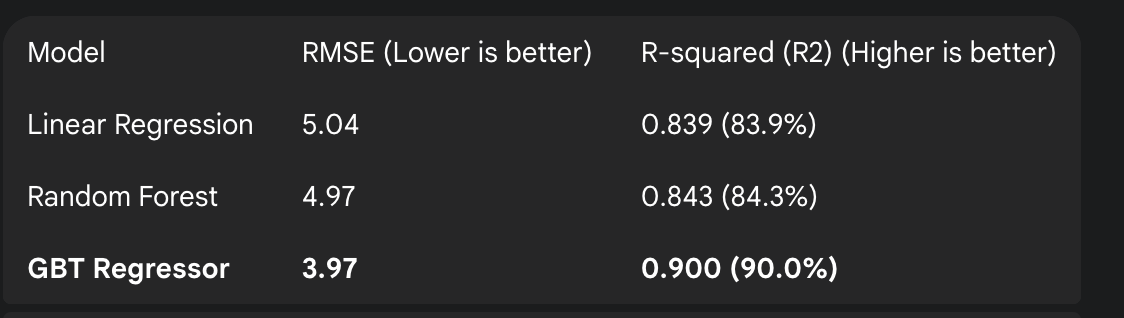

Why Not Use AdaBoost?

While AdaBoost is a well-known boosting algorithm, it was not used in this project for two primary reasons:

    Library Limitation: pyspark.ml (Spark's machine learning library) does not include an AdaBoostRegressor. It only provides AdaBoostClassifier, which cannot be used for a regression problem (predicting a continuous value like temperature).

    GBT is the Modern Successor: The GBTRegressor (Gradient-Boosted Tree) model that we are already using is the modern, more powerful, and more flexible evolution of the same boosting concept that AdaBoost pioneered. GBT is the industry-standard choice for high-performance regression on tabular data.

In short, we are already using a more powerful version of a boosting model, and the specific regression version of AdaBoost isn't available in Spark's ML library.